In [ ]:
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display  # 用于在 Jupyter Notebook 中显示图片

In [115]:
from rdkit import Chem
from rdkit.Chem import AllChem
import random

# ============ 1. 定义原料列表 ============

amine_head_list = [
    "NCCN1CCCC1",   # 实际含多个氮，未必是简单伯胺
    "C1CCN(C1)CCN",
    "NCCN1CCCCC1",
    "CCC1CCCCN1CCCN"
]

isocyanide_linker_list = [
    "CC(C)(C)OC(=O)C[N+]#[C-]", 
    "CC(C)(C)[N+]#[C-]",
    "[C-]#[N+]C1CCCCC1",
    "CCCC[N+]#[C-]"
]

Tail_1_list = [
    "CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC=O",
    "CCCCCCCCC(=O)OCCCCCC=O",
    "CCCCCCCCCCC(=O)OCCCCCC=O",
    "CCCCCCCCCCCCC(=O)OCCCCCC=O",
    "CCCCCCCCCCCCCCCC(=O)OCCCCCC=O",
    "CCCCCCCCCCCCCCCCCC(=O)OCCCCCC=O",
    "CCCCC/C=C\\C/C=C\\CCCCCCCC(=O)OCCCCCC=O",
    "CCCCCCCC/C=C\\CCCCCCCC(=O)OCCCCCC=O" 
]

Tail_2_list = [
    "CCCCCCCC/C=C\\CCCCCCCC(=O)O",
    "CCCCC/C=C\\C/C=C\\CCCCCCCC(=O)O",
    "CCCCCCCCCCCCCCCC(=O)O",
    "CCCCCCCCC(CCCCCCCC)OC(=O)CCCCC(=O)O"
]

# ============ 2. 定义两步反应 SMARTS ============

# Step 1: 只匹配末端醛(R–CH=O) + 伯胺(-NH2) => 亚胺
#   [CX3H1:1](=O)[CX4:2] 表示末端醛碳(sp2, 带1氢)连着一个sp3碳
#   [NH2:3] 表示伯胺
imine_reaction_smarts = "[CX3H1:1](=O)[CX4:2].[NH2:3]>>[CX3H1:1](=[N:3])[CX4:2]"
rxn_imine = AllChem.ReactionFromSmarts(imine_reaction_smarts)

# Step 2: 亚胺 + 异腈 + 羧酸 => Ugi 产物 (简化示例)
# 这里用 [C-]#[N+] 表示异腈
ugi_reaction_smarts = "[C:1](=[N:2]).[C-:3]#[N+:4].[C:5](=[O:6])O>>[C:1]-[N+:4]-[C-:3]-[N:2]-[C:5](=[O:6])"
rxn_ugi = AllChem.ReactionFromSmarts(ugi_reaction_smarts)



In [116]:
# ============ 3. Step 1: 生成亚胺 ============

imine_mols = []
for amine_smiles in amine_head_list:
    mol_amine = Chem.MolFromSmiles(amine_smiles)
    if not mol_amine:
        continue

    for aldehyde_smiles in Tail_1_list:
        mol_aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
        if not mol_aldehyde:
            continue

        # 运行 Step 1
        products_step1 = rxn_imine.RunReactants((mol_aldehyde, mol_amine))
        if not products_step1:
            continue

        for prod_tuple in products_step1:
            # prod_tuple 是可能的产物集合
            for prod_mol in prod_tuple:
                try:
                    Chem.SanitizeMol(prod_mol)
                    imine_mols.append(prod_mol)
                except:
                    pass

print(f"\nStep 1 生成亚胺数: {len(imine_mols)}")
if len(imine_mols) == 0:
    print("【提示】由于没有匹配到末端醛(-CHO)与伯胺(-NH2)，无法生成亚胺。")




Step 1 生成亚胺数: 32


CSV 文件已保存为 imine_mols.csv


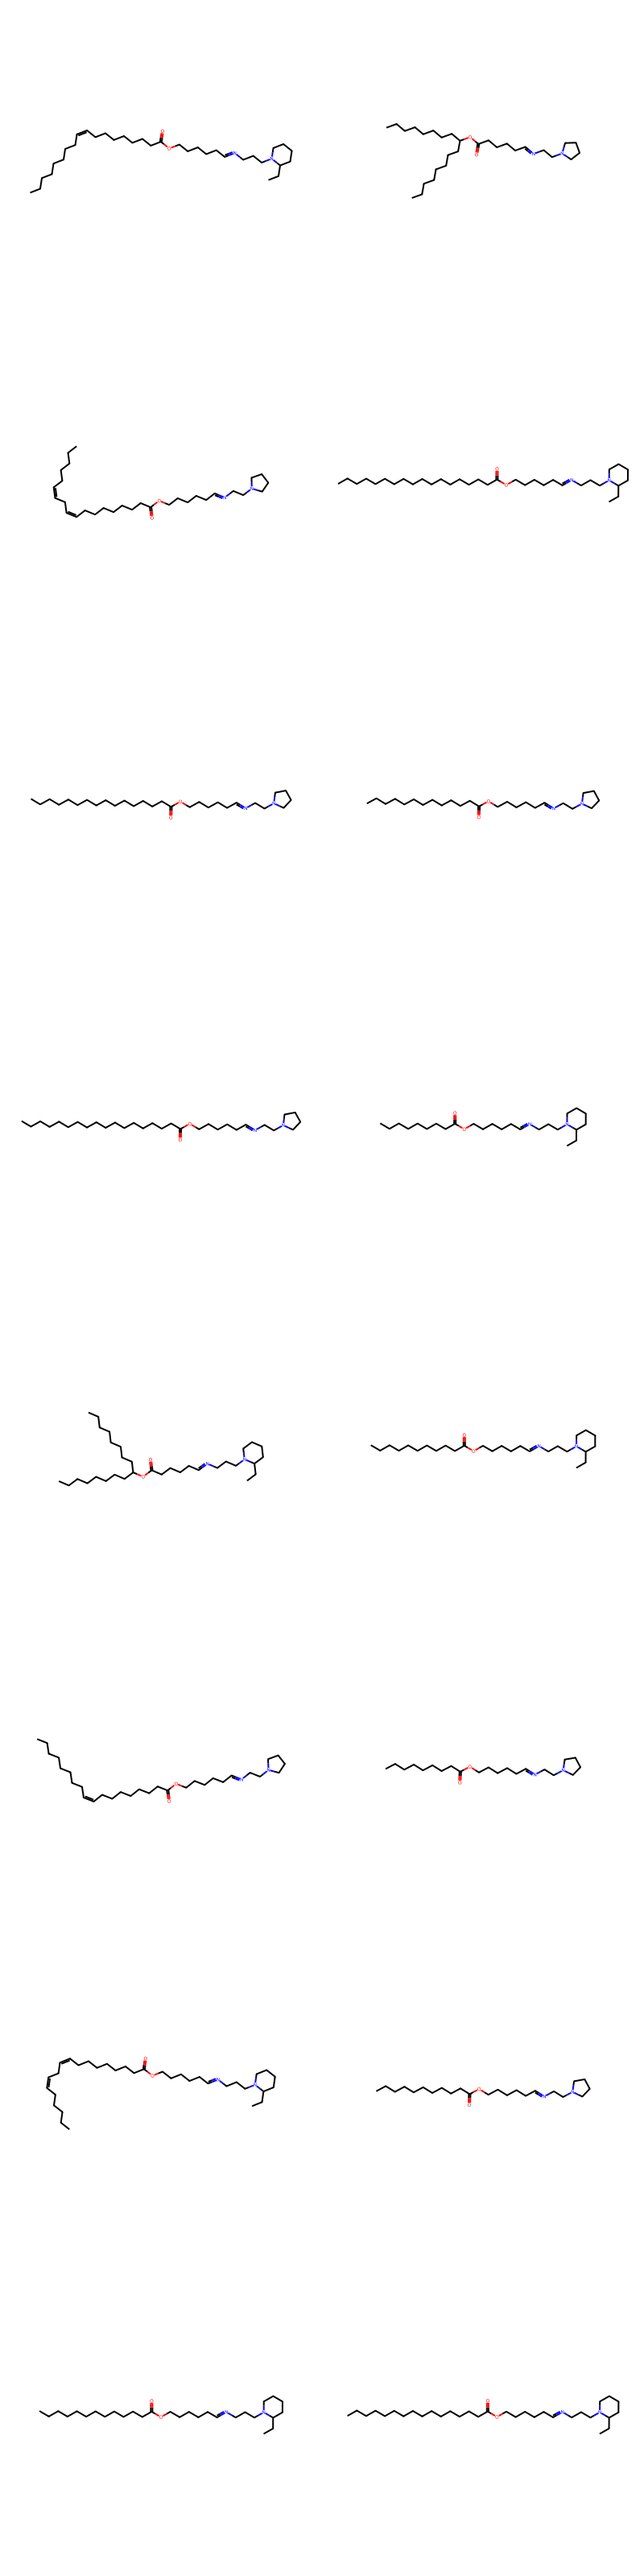

In [118]:
# 1. 去重并获取产物的 SMILES
#unique_smiles = list(set(Chem.MolToSmiles(m, isomericSmiles=True) for m in imine_mols))

# 2. 将 SMILES 再转成 Mol 对象，以便可视化
#unique_products = [Chem.MolFromSmiles(smi) for smi in unique_smiles if smi]

#print(f"去重后产物数: {len(unique_products)}")

# =========== 将最终产品保存到 CSV 文件 ===========
csv_filename = "imine_mols.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["编号", "SMILES"])  # CSV 第一列：编号，第二列：SMILES
    for idx, smi in enumerate(unique_smiles, start=1):
        writer.writerow([idx, smi])

print(f"CSV 文件已保存为 {csv_filename}")

# =========== 使用网格图展示最终产品 ===========
# 每行显示2个分子，子图大小(400,400)
img = Draw.MolsToGridImage(unique_products, molsPerRow=2, subImgSize=(400, 400))
display(img)

In [119]:

# ============ 4. Step 2: 生成最终 Ugi 产物 ============

final_products = []
for imine_mol in imine_mols:
    for iso_smiles in isocyanide_linker_list:
        mol_iso = Chem.MolFromSmiles(iso_smiles)
        if not mol_iso:
            continue

        for acid_smiles in Tail_2_list:
            mol_acid = Chem.MolFromSmiles(acid_smiles)
            if not mol_acid:
                continue

            # 运行 Step 2
            products_step2 = rxn_ugi.RunReactants((imine_mol, mol_iso, mol_acid))
            if not products_step2:
                continue

            for p2 in products_step2:
                for prod_mol in p2:
                    try:
                        Chem.SanitizeMol(prod_mol)
                        final_products.append(prod_mol)
                    except:
                        pass

print(f"Step 2 生成最终 Ugi 产物数: {len(final_products)}")




Step 2 生成最终 Ugi 产物数: 640


去重后产物数: 480
产物: CCCCC/C=C\C/C=C\CCCCCCCC(=O)N([CH-][NH+]([CH]CCCCCOC(=O)CCCCCCCCCCCCCCCCC)CC(=O)OC(C)(C)C)CCN1CCCC1
产物: CCCCCCCCC(=O)OCCCCC[CH][NH+]([CH-]N(CCN1CCCC1)C(=O)CCCCC(=O)OC(CCCCCCCC)CCCCCCCC)CC(=O)OC(C)(C)C
产物: CCCCC/C=C\C/C=C\CCCCCCCC(=O)N([CH-][NH+]([CH]CCCCCOC(=O)CCCCCCCCCCCCCCC)C1CCCCC1)CCN1CCCC1
产物: CCCCCCCCCCCCCCCC(=O)N([CH-][NH+]([CH]CCCCCOC(=O)CCCCCCCCCCCC)C(C)(C)C)CCCN1CCCCC1CC
产物: CCCCCCCCCCCCCCCC(=O)N([CH-][NH+]([CH]CCCCCOC(=O)CCCCCCCCCC)C1CCCCC1)CCCN1CCCCC1CC
去重后产物数: 480
CSV 文件已保存为 final_products.csv


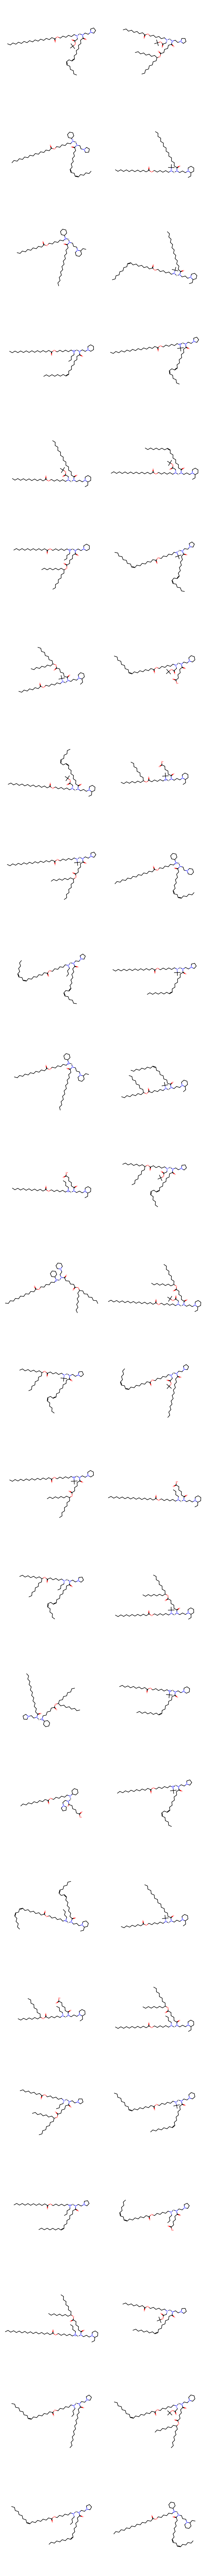

In [120]:
# ============ 5. 可视化或导出部分产物 ============

# 去重 & 转成SMILES
unique_smiles = list(set(Chem.MolToSmiles(m) for m in final_products))
print(f"去重后产物数: {len(unique_smiles)}")

# 打印前 5 条产物 SMILES
for s in unique_smiles[:5]:
    print("产物:", s)

# 1. 去重并获取产物的 SMILES
unique_smiles = list(set(Chem.MolToSmiles(m, isomericSmiles=True) for m in final_products))

# 2. 将 SMILES 再转成 Mol 对象，以便可视化
unique_products = [Chem.MolFromSmiles(smi) for smi in unique_smiles if smi]

print(f"去重后产物数: {len(unique_products)}")

# =========== 将最终产品保存到 CSV 文件 ===========
csv_filename = "final_products.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["编号", "SMILES"])  # CSV 第一列：编号，第二列：SMILES
    for idx, smi in enumerate(unique_smiles, start=1):
        writer.writerow([idx, smi])

print(f"CSV 文件已保存为 {csv_filename}")

# =========== 使用网格图展示最终产品 ===========
# 每行显示2个分子，子图大小(400,400)
img = Draw.MolsToGridImage(unique_products, molsPerRow=2, subImgSize=(400, 400))
display(img)

In [122]:
import os
os.makedirs("product_images", exist_ok=True)

for i, mol in enumerate(unique_products, start=1):
    if mol is None:
        continue
    # 为每个产物生成独立文件名
    filename = f"product_images/product_{i}.png"
    # 将分子保存为 PNG 图片
    Draw.MolToFile(mol, filename, size=(600,600))
    print(f"已保存: {filename}")

已保存: product_images/product_1.png
已保存: product_images/product_2.png
已保存: product_images/product_3.png
已保存: product_images/product_4.png
已保存: product_images/product_5.png
已保存: product_images/product_6.png
已保存: product_images/product_7.png
已保存: product_images/product_8.png
已保存: product_images/product_9.png
已保存: product_images/product_10.png
已保存: product_images/product_11.png
已保存: product_images/product_12.png
已保存: product_images/product_13.png
已保存: product_images/product_14.png
已保存: product_images/product_15.png
已保存: product_images/product_16.png
已保存: product_images/product_17.png
已保存: product_images/product_18.png
已保存: product_images/product_19.png
已保存: product_images/product_20.png
已保存: product_images/product_21.png
已保存: product_images/product_22.png
已保存: product_images/product_23.png
已保存: product_images/product_24.png
已保存: product_images/product_25.png
已保存: product_images/product_26.png
已保存: product_images/product_27.png
已保存: product_images/product_28.png
已保存: product_images/product_2

In [123]:
ls

4CR_Accelerate.ipynb            final_products.csv    smart_reaction_3A.ipynb
A3_double_coupling_library.sdf  grok_A3.ipynb         Untitled1.ipynb
A3_DS.ipynb                     imine_mols.csv        Untitled2.ipynb
A3_final_0304.ipynb             LNP_A3_cleanV1.ipynb  Untitled3.ipynb
A3_gpt.ipynb                    LNP_A3.ipynb          Untitled4.ipynb
A4_test.ipynb                   product_images/       Untitled.ipynb


In [124]:
pwd

'/mnt/data/share/wq/soft/AI_LNP'